In [9]:
import pickle
import pandas as pd
import sklearn.svm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

## Minor pandas test

In [10]:
#df = pd.read_pickle(r"storing_results\trials_test_9627117.p")
d= torch.load(r"storing_results\trials_test.p",map_location=torch.device('cpu'), pickle_module=pickle)

In [144]:
df.columns

Index(['state', 'tid', 'spec', 'result', 'misc', 'exp_key', 'owner', 'version',
       'book_time', 'refresh_time'],
      dtype='object')

## Code for violinplots
Has been copied to /analysis/make_violin_plots.py

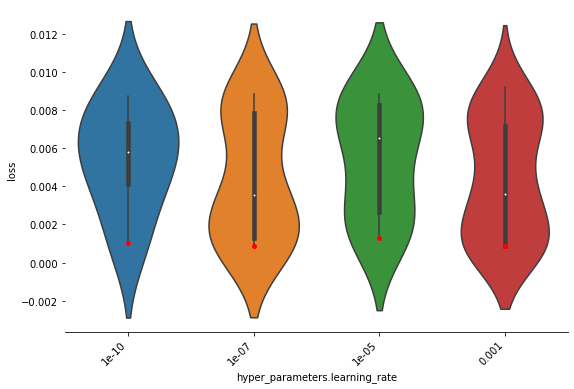

In [35]:
trials = pickle.load(open("storing_results/trials_test.p", "rb"))
df = pd.json_normalize(trials.results)
df = df[df["loss"] != 10] # filter out bad model results

fig, ax = plt.subplots(figsize=(9, 6))
sns.violinplot(x="hyper_parameters.learning_rate", y="loss", data=df)

minimum = df[["loss", "hyper_parameters.learning_rate"]].groupby('hyper_parameters.learning_rate').min().reset_index()
sns.swarmplot(x = 'hyper_parameters.learning_rate', y='loss', data=minimum,  color='r')

_ = plt.xticks(rotation=45, ha='right')

sns.despine(left=True)

# Some analysis on the models of the results

In [38]:
df_loss_ocsvm = df[["loss", "final_cost", "model.ocsvm"]]
df_loss_ocsvm.head()

,loss,final_cost,model.ocsvm
2,0.006604,0.691407,"OneClassSVM(kernel='linear', nu=0.05)"
8,0.008763,0.583097,"OneClassSVM(kernel='linear', nu=0.05)"
9,0.003763,0.148970,"OneClassSVM(kernel='linear', nu=0.05)"
10,0.008824,0.157277,"OneClassSVM(gamma='auto', kernel='linear', nu=..."
12,0.001020,0.302543,"OneClassSVM(gamma='auto', kernel='linear', nu=..."


## Occurences of unique loss values

This is strange... Our loss seems to output the same values most of the time.

Could be because:
- no randomness -> each hyperparameter configuration will lead to the exact same loss result
- the lowest loss value is favoured, so hyperopt will use this setting the most

In [45]:
df['final_cost'].value_counts()

0.691407    1
0.016737    1
0.066878    1
0.130848    1
0.001010    1
0.006984    1
0.020754    1
0.016021    1
0.035149    1
0.020306    1
0.003514    1
0.053222    1
0.001470    1
0.026303    1
0.024736    1
0.019976    1
0.092518    1
0.069027    1
0.009043    1
0.006820    1
0.021680    1
0.100294    1
0.033990    1
0.009418    1
0.042305    1
0.022259    1
0.040834    1
0.011829    1
0.039404    1
0.205002    1
0.583097    1
0.115992    1
0.148970    1
0.157277    1
0.302543    1
0.667054    1
1.039114    1
0.638495    1
0.308210    1
0.000597    1
0.219620    1
0.101829    1
0.006754    1
0.202531    1
0.057659    1
0.120322    1
0.049036    1
0.114240    1
0.071943    1
0.137137    1
0.041363    1
0.352906    1
0.435975    1
0.004289    1
0.268810    1
0.184767    1
0.406211    1
0.167620    1
0.017223    1
Name: final_cost, dtype: int64

In [ ]:
df = df[df["loss"] != -1] # filter out -1s for now

## Alphas vs loss vs cost?

The number of alphas does not seem to greatly affect the loss too much. 
This should be checked with the cost however, since alphas are used for its calculation.

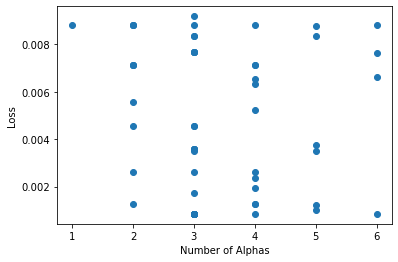

In [43]:
oc_svms = df_loss_ocsvm["model.ocsvm"]
alphas = [np.abs(ocsvm.dual_coef_)[0] for ocsvm in df_loss_ocsvm["model.ocsvm"]]
plt.scatter([len(a) for a in alphas], df_loss_ocsvm["loss"])
plt.xlabel("Number of Alphas")
plt.ylabel("Loss")
plt.show()

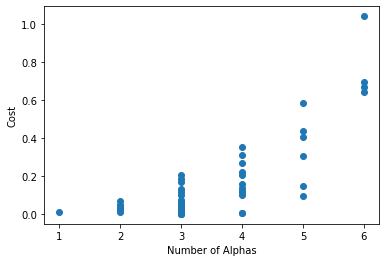

In [42]:
oc_svms = df_loss_ocsvm["model.ocsvm"]
alphas = [np.abs(ocsvm.dual_coef_)[0] for ocsvm in df_loss_ocsvm["model.ocsvm"]]
plt.scatter([len(a) for a in alphas], df_loss_ocsvm["final_cost"])
plt.xlabel("Number of Alphas")
plt.ylabel("Cost")
plt.show()

# Other stuff, can be deleted 

In [178]:
s = "batch_size"
print(df.keys())

Index(['loss', 'status', 'model.lstm:', 'model.ocsvm', 'model.scaler',
       'hyper_parameters.batch_size', 'hyper_parameters.decay_factor',
       'hyper_parameters.dropout', 'hyper_parameters.hidden_dim',
       'hyper_parameters.learning_rate', 'hyper_parameters.min_epochs',
       'hyper_parameters.num_layers', 'hyper_parameters.output_dim',
       'hyper_parameters.svm_gamma', 'hyper_parameters.svm_nu'],
      dtype='object')


In [179]:
key = df.keys()[[s in key for key in df.keys()]][0]

In [195]:
for key in trials.results[0]['hyper_parameters'].keys():
    print(key)

batch_size
decay_factor
dropout
hidden_dim
learning_rate
min_epochs
num_layers
output_dim
svm_gamma
svm_nu


In [182]:
from hyperopt import hp
space = hp.choice(
    "hyper_parameters",
    [
        {
            "batch_size": hp.choice("num_batch", [50, 100, 200]),
            "hidden_dim": hp.choice("hidden_dim", [2, 6, 18]),
            "num_layers": hp.choice("num_layers", [1]),
            "min_epochs": hp.choice("min_epochs", [int(5), int(10), int(20)]),
            "learning_rate": hp.choice(
                "learning_rate", [1e-3, 1e-5, 1e-7, 1e-5, 1e-10, 1e-15]
            ),
            "decay_factor": hp.choice("decay_factor", [0.5, 0.7, 0.8]),
            "dropout": hp.choice("dropout", [0]),  # , 0.2, 0.4, 0.6]),
            "output_dim": hp.choice("output_dim", [1]),
            "svm_nu": hp.choice("svm_nu", [0.05]),  # 0.5 was the default
            "svm_gamma": hp.choice(
                "svm_gamma", ["scale", "auto"]  # Auto seems to give weird results
            ),  # , "scale", , "auto"[ 0.23 was the defeault before]
        }
    ],
)